# 04 - Applied ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from pandas.plotting import scatter_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
import seaborn as sns
import networkx as nx
%matplotlib inline

# Question 1
## 1. A naive analysis

In [2]:
data = pd.read_csv('lalonde.csv')
data.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [3]:
def plot_feature(feature_name, data):
    r_min = data[feature_name].min()
    r_max = data[feature_name].max()
    
    data_treated = data[data["treat"] == 1]
    data_untreated = data[data["treat"] == 0]
    
    plt.figure(figsize=(16,6))
    plt.suptitle(feature_name, fontsize=20)
    ax = plt.subplot(1,2,1)
    plt.hist(data_treated[feature_name], normed=True, bins=20, range=(r_min, r_max))
    plt.title("Treated people", fontsize=14)
    plt.subplot(1,2,2, sharey=ax)
    plt.title("Untreated people", fontsize=14)
    plt.hist(data_untreated[feature_name], normed=True, bins=20, range=(r_min, r_max))
    plt.show()

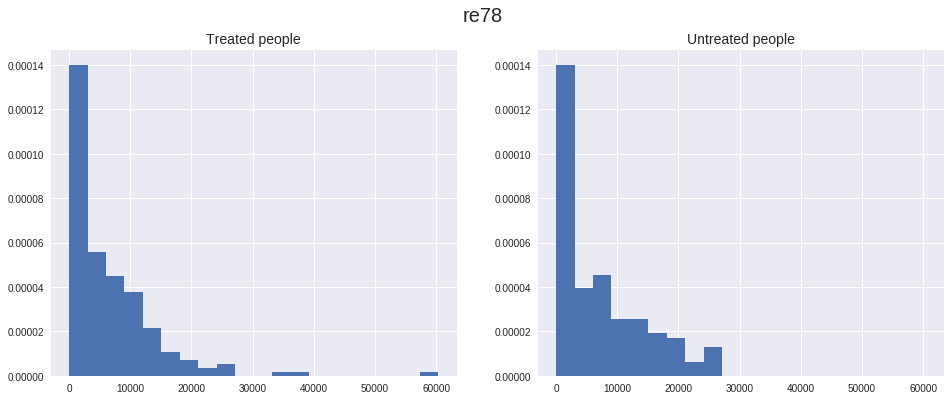

In [7]:
plot_feature('re78', data)

## 2. A closer look at the data

In [8]:
data_features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75', 're78']
data_features.remove('re78')
data_features

['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

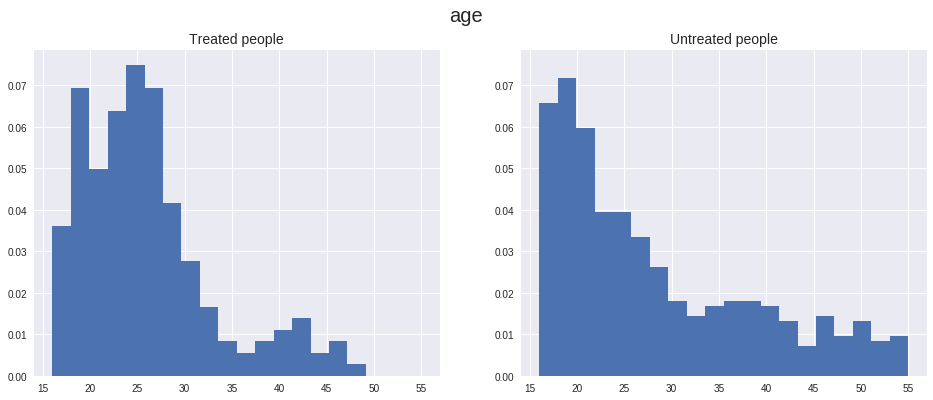

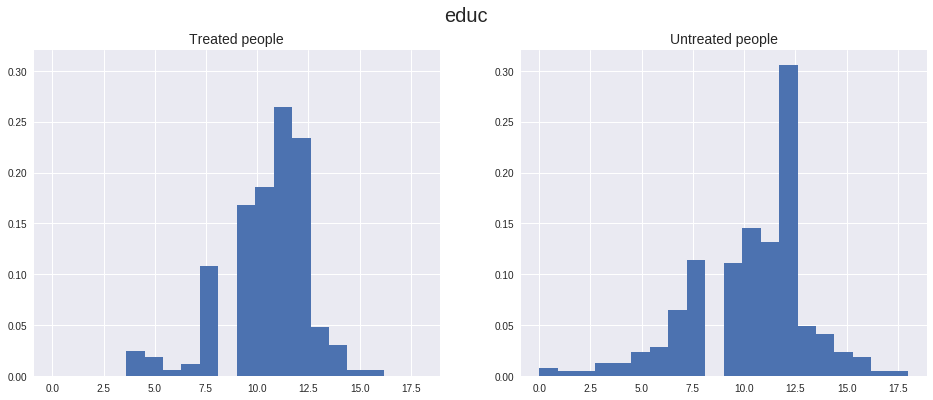

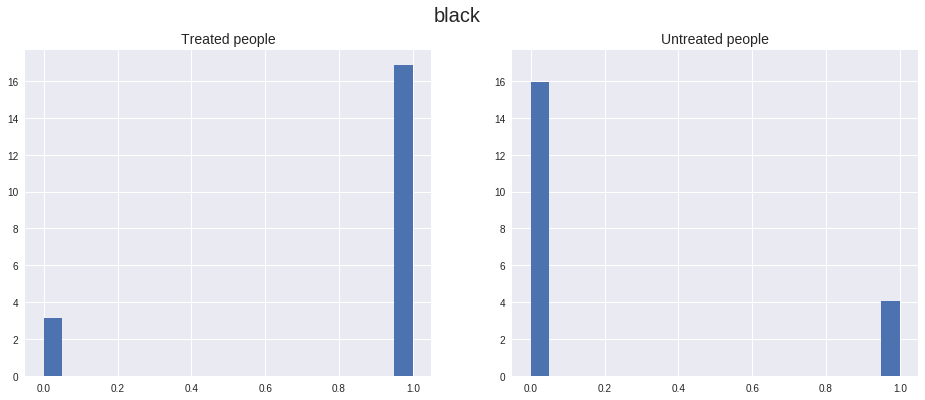

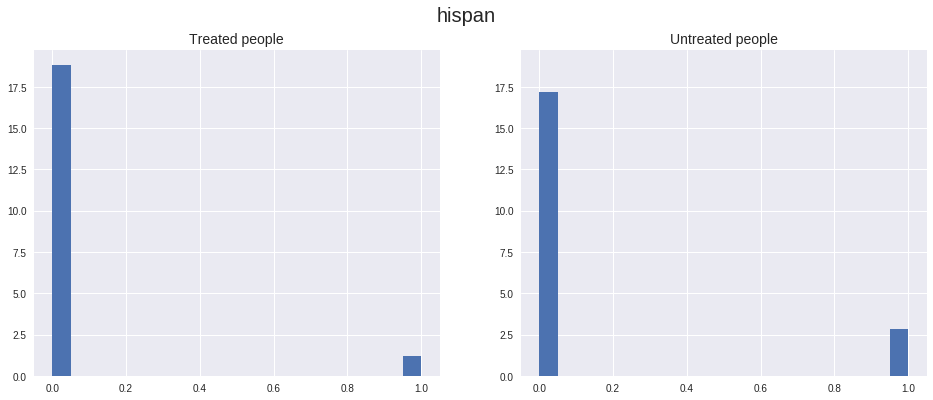

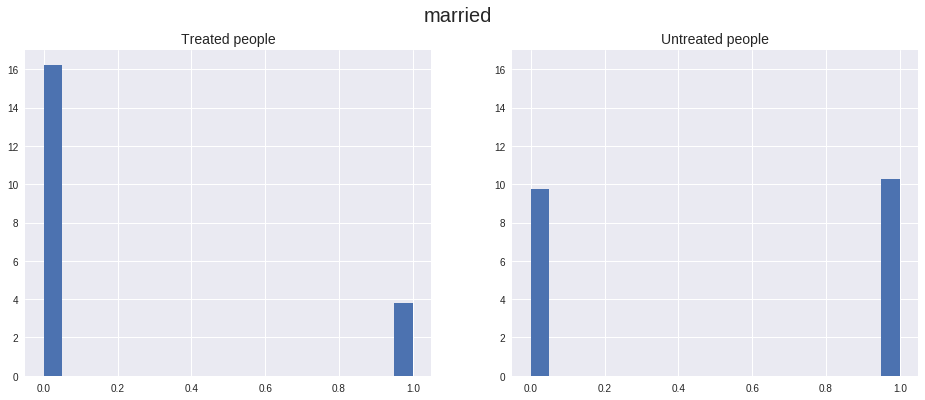

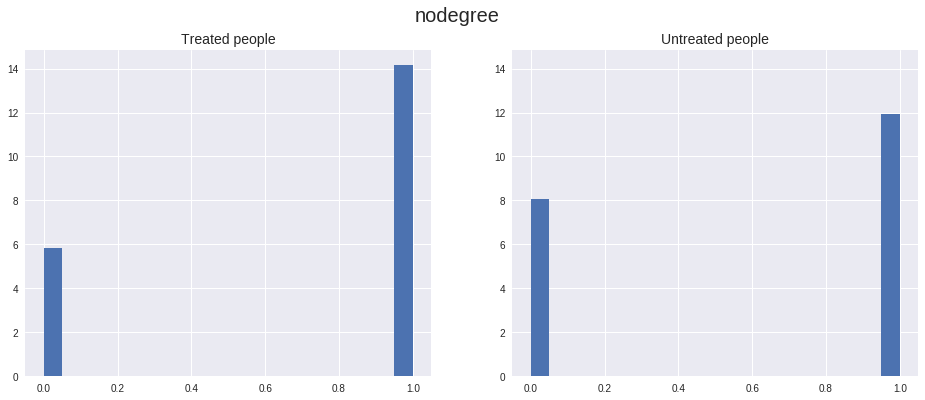

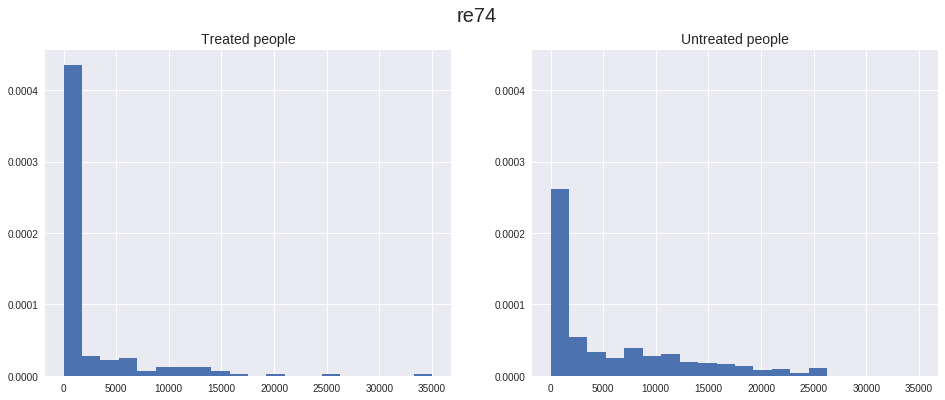

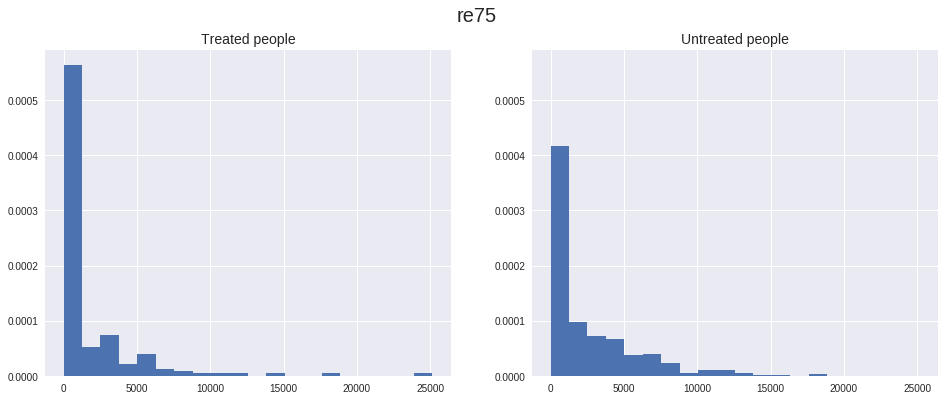

In [15]:
for col in ["age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75"]:
    plot_feature(col, data)

## 3. A propsensity score model

In [10]:
# The features vector
X = data[data_features]
# The label vector
y = data['treat']

logistic = LogisticRegression()
logistic.fit(X, y)
pred_prob = logistic.predict_proba(X)
pred_prob

array([[ 0.55664958,  0.44335042],
       [ 0.85534047,  0.14465953],
       [ 0.27764537,  0.72235463],
       ..., 
       [ 0.87687096,  0.12312904],
       [ 0.44954003,  0.55045997],
       [ 0.84497047,  0.15502953]])

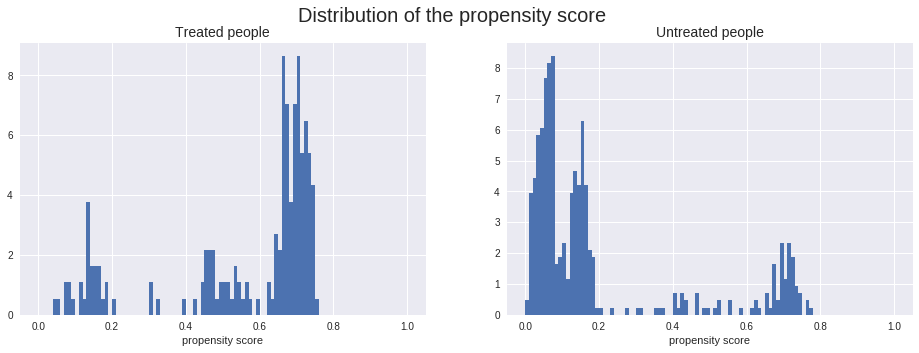

0.561869387932
0.196656023697


In [11]:
treated_idx = np.where(data['treat'] == 1)[0]
untreated_idx = np.where(data['treat'] == 0)[0]

pred_prob_treated = pred_prob[treated_idx, 1]
pred_prob_untreated = pred_prob[untreated_idx, 1]

plt.figure(figsize=(16,5))
plt.suptitle("Distribution of the propensity score", fontsize=20)
plt.subplot(1,2,1)
plt.hist(pred_prob_treated, bins=100, range=(0, 1), normed=True)
plt.xlabel('propensity score')
plt.title("Treated people", fontsize=14)

plt.subplot(1,2,2)
plt.hist(pred_prob_untreated, bins=100, range=(0, 1), normed=True)
plt.title("Untreated people", fontsize=14)
plt.xlabel('propensity score')
plt.show()

print(np.mean(pred_prob_treated))
print(np.mean(pred_prob_untreated))

## 4. Balancing the dataset via matching

In [12]:
g = nx.graph.Graph()
    
for index in data.index:
    g.add_node(index)
    
for t_index in treated_idx:
    for unt_index in untreated_idx:
        dist = np.abs(pred_prob[t_index, 1] - pred_prob[unt_index, 1])
        g.add_edge(t_index, unt_index, weight=1 - dist)
        
matching = nx.max_weight_matching(g)

In [13]:
matched_idx = list(matching.keys())
matched_data = data.iloc[matched_idx,:]
matched_treated = matched_data[matched_data["treat"] == 1]
matched_untreated = matched_data[matched_data["treat"] == 0]

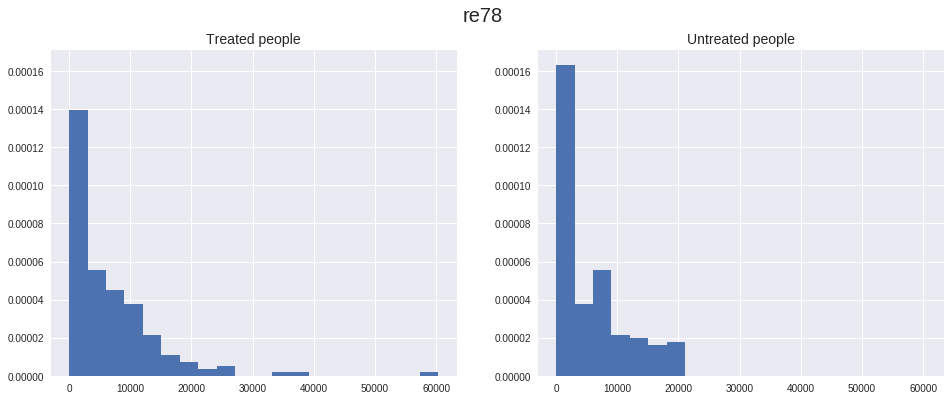

In [14]:
plot_feature("re78", matched_data)

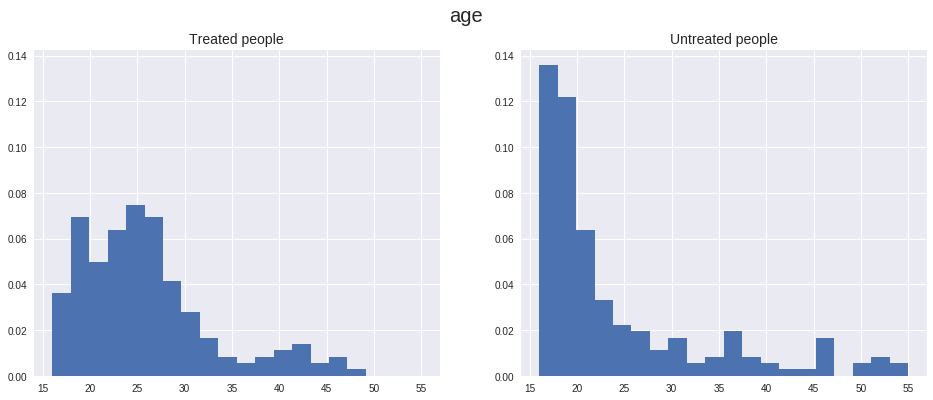

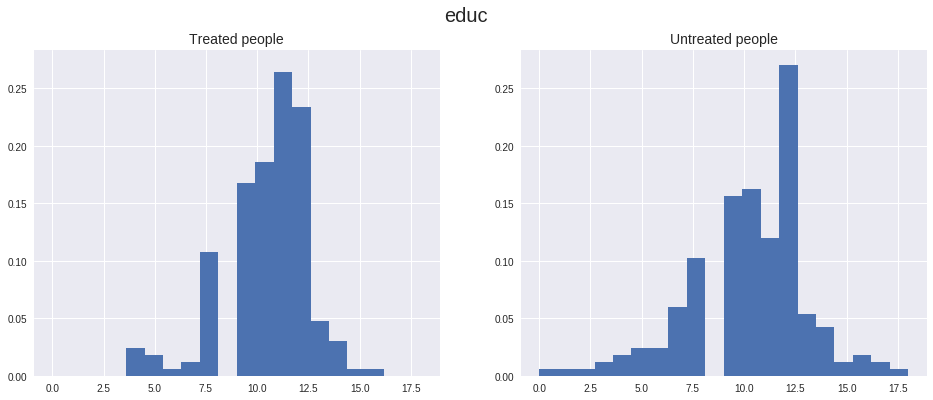

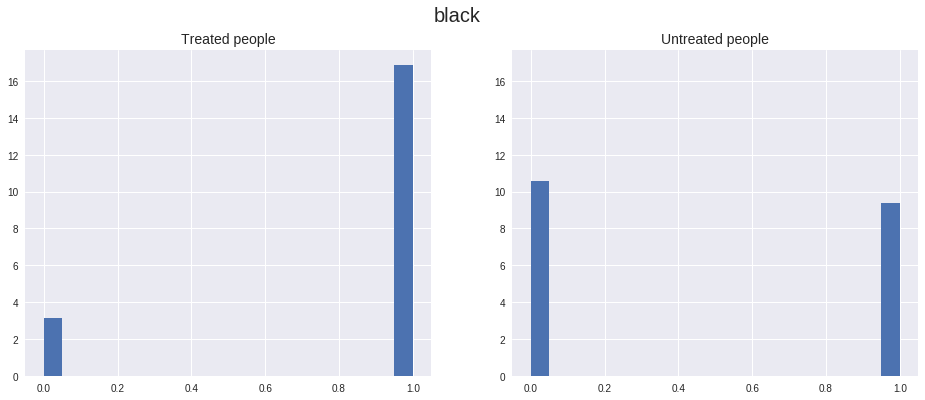

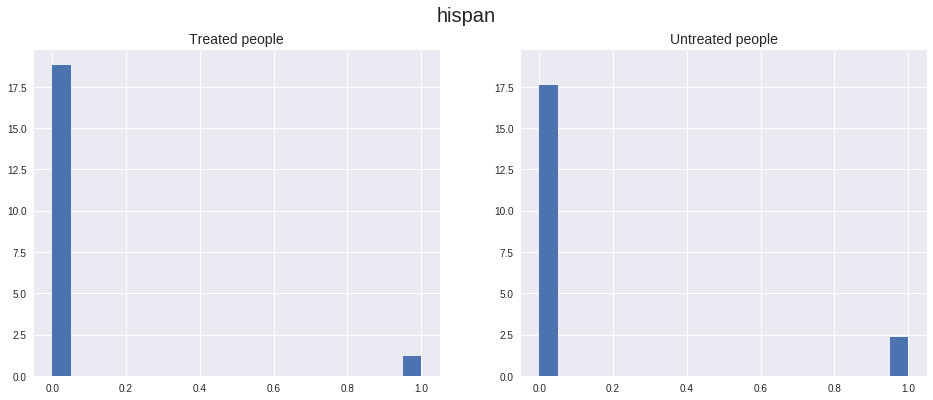

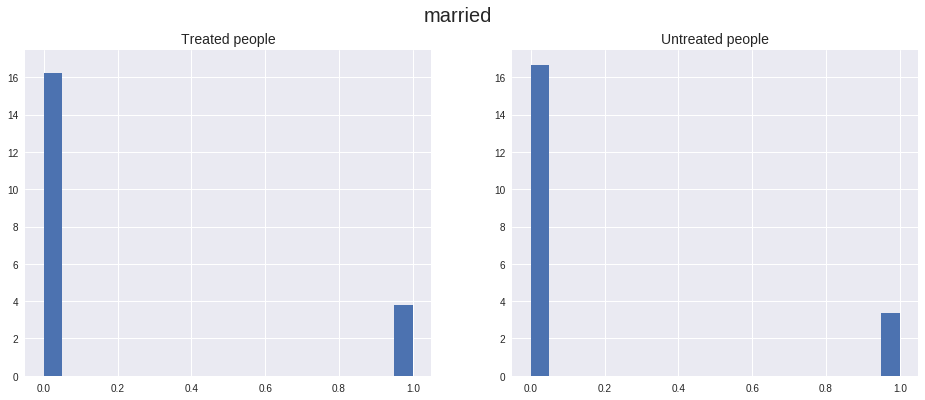

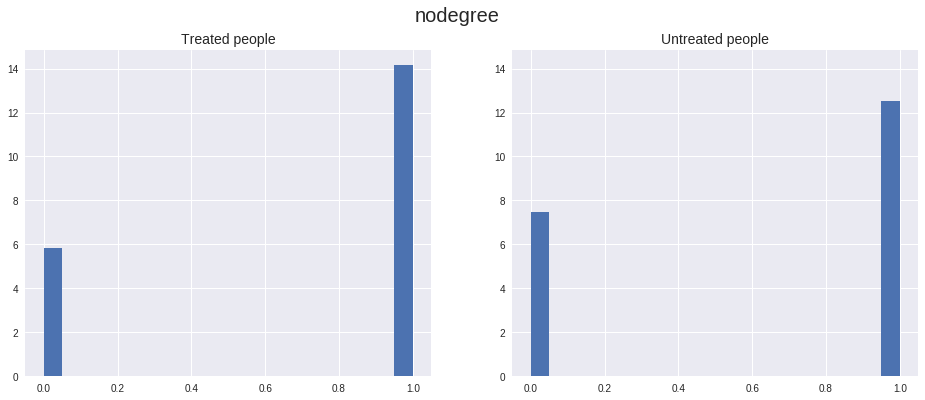

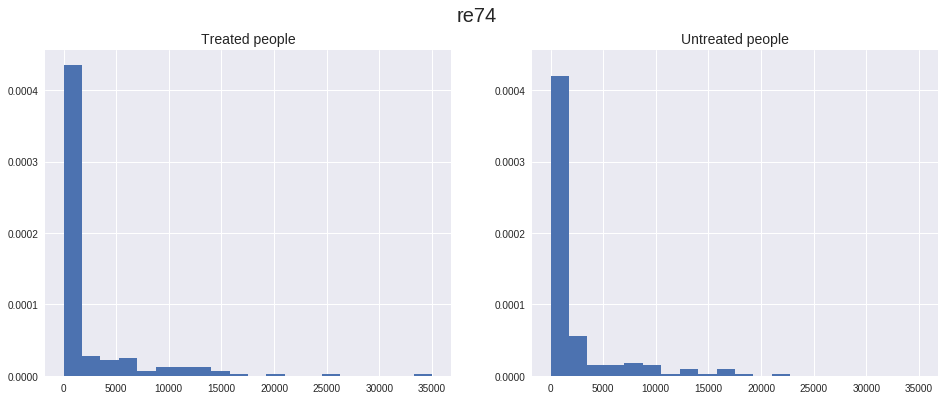

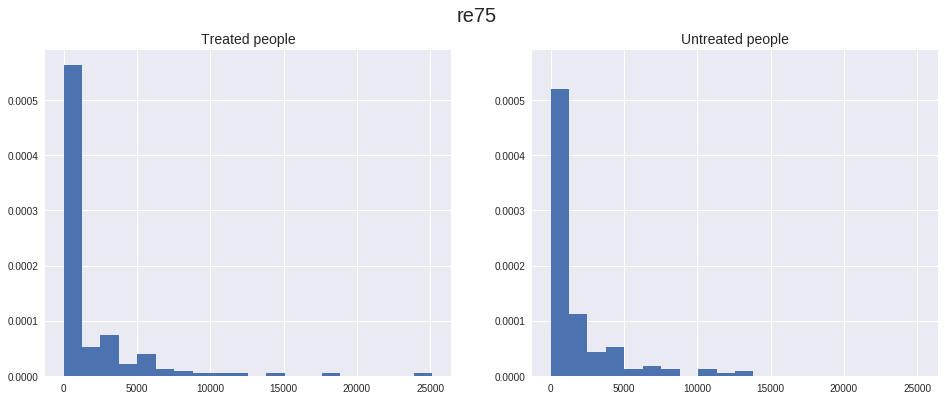

In [16]:
for col in ["age", "educ", "black", "hispan", "married", "nodegree", "re74", "re75"]:
    plot_feature(col, matched_data)

The data has a similar distribution, the treated group can now be compared with the control group.

## 5. Balancing the groups further

We notice that the black feature does not balance well enough making it diffucult to draw valid conclusion on the treatement. We will explicitly match only if this feature matches.

## 6. A less naive analysis

# Question 2: Applied ML